In [1]:
__author__ = 'Robert Nikutta <nikutta@noao.edu>, Stéphanie Juneau <juneau@noao.edu>, Knut Olsen <kolsen@noao.edu>, David Nidever <dnidever@noao.edu>'
__version__ = '20210407' # yyyymmdd; version stamp of this notebook
__datasets__ = ['delve_dr1'] # datasets used in this notebook
__keywords__ = ['science example','dwarf galaxies'], # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] 

# Detecting the Centaurus I dwarf galaxy in DELVE DR1
*Jonah Medoff*

*Adapted from "Detecting the Hydra II dwarf galaxy in SMASH DR1" by Robert Nikutta, Stéphanie Juneau, Knut Olsen, David Nidever & NOAO Data Lab Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports & setup](#import)
* [Query the DELVE catalog for blue stars (expected in metal-poor dwarfs)](#query)
* [Spatial density plot](#spatial)
* [Detect overdensities (differential Gaussian kernels)](#kernel)
* [Find peaks](#peaks)
* [Visually inspect images (Simple Image Access)](#sia)
* [CM diagrams of all stars around the peaks](#cmdiagrams)
* [Save your results to a local file](#savefile)
* [Resources](#resource)


<a class="anchor" id="goals"></a>
# Goals

We will use a dwarf galaxy detection algorithm using a spatial overdensity of blue stars to re-discover the Centaurus I dwarf galaxy in the DELVE DR1 dataset ([Mau et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...890..136M/abstract)).


# Summary

**Background**
Ultrafaint dwarf galaxies are crucial to understanding many aspects of the universe. For instance, they are dominated by dark matter; their localization in space can thus trace the large-scale structure of the dark matter distribution. Furthermore, dwarf galaxies are suspected to host intermediate-mass black holes (IMBH), which so far have eluded efforts to find them. IMBHs will naturally bridge the gap between the solar-mass black hole and super-massive blackholes that reside at the center of virtually every large galaxy.

**Data retrieval**
We will retrieve data at RA=189.58 and Dec=-40.89 in the DELVE catalog ([Drlica-Wagner et al. 2021](https://ui.adsabs.harvard.edu/abs/2021arXiv210307476D/abstract)) and look for overdensities of blue objects.

The required columns are RA, Dec, and the g, r, i magnitudes.

**Detection**
We will convolve the spatial distribution of our dataset with a pair of Gaussian kernels and subtract the results, as done in e.g. [Stanford et al. (2005, ApJ, 634, 2, L129)](http://adsabs.harvard.edu/abs/2005ApJ...634L.129S) (galaxy clusters), or [Koposov et al. (2008, ApJ, 686, 279)](http://adsabs.harvard.edu/abs/2008ApJ...686..279K) (MW satellites). This has the effect of convolving the spatial distribution with a Mexican hat filter, which is useful for detecting objects at a desired spatial scale.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/disclaimers.php

* DELVE papers: [Mau et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...890..136M/abstract), [Drlica-Wagner et al. 2021](https://ui.adsabs.harvard.edu/abs/2021arXiv210307476D/abstract)

# Imports and setup

In [2]:
# std lib
from getpass import getpass
import warnings
warnings.filterwarnings('ignore') # to suppress some astropy deprecation warnings

# 3rd party
import numpy as np
from numpy.core.defchararray import startswith, count
from astropy import utils, io, convolution, stats
from astropy.visualization import make_lupton_rgb, simple_norm
from photutils import find_peaks
from pyvo.dal import sia
import pylab as plt
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.wcs import WCS
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc
from dl.helpers.utils import convert

# plots default setup
plt.rcParams['font.size'] = 14

 <a class="anchor" id="query"></a>
# Query the DELVE DR1 database

We will query the photometry table from the DELVE DR1 catalog and select ra=189.58 and dec=-40.89.  We will limit the query to pick blue objects (-0.4 < g-r < 0.4).

## Construct the query string

In [3]:
ra = 189.58
dec = -40.89

# Create the query string; SQL keyword capitalized for clarity

query =\
"""SELECT ra,dec,mag_auto_g,mag_auto_r,mag_auto_i
   FROM delve_dr1.objects
   WHERE q3c_radial_query(ra, dec, 189.58, -40.89, 0.5) AND
         mag_auto_g BETWEEN 14 AND 25 AND
         (mag_auto_g - mag_auto_r) BETWEEN -0.4 AND 0.4""".format(ra, dec)

# Submit the query
Running the query in synchroneous mode is very easy.

In [4]:
%time
response = qc.query(sql=query) # response is by default a CSV-formatted string

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


We can use a helper function to convert the query result into a data structure. Let's convert to a pandas DataFrame:

In [5]:
R = convert(response,'pandas') # R is a pandas DataFrame
print("Number of objects:", R.shape[0])
print(R.head())

Number of objects: 2969
           ra        dec  mag_auto_g  mag_auto_r  mag_auto_i
0  189.931135 -41.209276     15.0143     14.6464     14.5399
1  188.943488 -40.777817     15.2327     14.8469     99.0000
2  189.459305 -40.889507     15.2151     15.3616     15.4705
3  189.605405 -41.320640     16.3071     16.2345     16.2315
4  190.001421 -40.680165     16.0141     15.6196     15.4918


<a class="anchor" id="spatial"></a>
# Make a figure of the spatial distribution

You might spot an overdensity already.

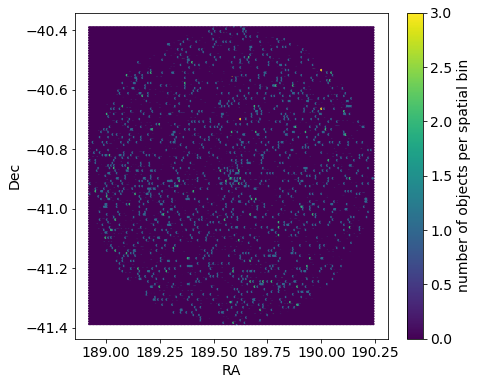

In [6]:
fig = plt.figure(figsize=(7,6))
plt.hexbin(R['ra'], R['dec'],gridsize=200)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar(label='number of objects per spatial bin');

<a class="anchor" id="kernel"></a>
# The Dwarf Filter
Here we define the dwarf filter as a differential convolution of a two-dimensional image using two Gaussian kernels; this has the effect of convolution with a Mexican hat filter.  The default kernel shapes look for objects on the scale of a few arcmin.  The output includes a clipped array of the convolved spatial distribution, which we will use for peak detection.

In [7]:
def dwarf_filter (ra,dec,fwhm_small=2.0,fwhm_big=20):

    """Differential convolution with 2D Gaussian kernels.
    
       Based on Koposov et al. (2008).
       Code by Ken Mighell and Mike Fitzpatrick.
       Minor edits by RN.
       
       Parameters
       ----------
       ra, dec : float or array
           RA & Dec in degrees.
    
       fwhm_small, fwhm_big : float
           Full-width half maximum sizes of the small and big Gaussian kernels
           to use in convolution, in arcminutes.
    """
    
    x, y = ra, dec

    print("Computing differential convolution .... ",)

    # Information about declination (y) [degrees]
    ymean = (y.min() + y.max()) / 2.0
    ydiff_arcmin = (y.max() - y.min()) * 60.0 # convert from degrees to arcmin

    # Information about right ascension (x) [degrees in time]:
    xdiff = x.max() - x.min() # angular separation [degrees (time)] 
    xmean = (x.min() + x.max()) / 2.0

    # convert from degrees in time to separation in angular degrees:
    xdiff_angular = (x.max() - x.min()) * np.cos(ymean*(np.pi/180.0))

    # convert from degress to arcmin
    xdiff_angular_arcmin = xdiff_angular * 60.0 

    # Get the number of one-arcmin pixels in the X and Y directions:
    nx = np.rint(xdiff_angular_arcmin).astype('int')
    ny = np.rint(ydiff_arcmin).astype('int')

    # Create a two-dimensional histogram of the raw counts:
    Counts, xedges, yedges  = np.histogram2d (x, y, (nx,ny) )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    raw_hist = np.rot90(Counts).copy() # hack around Pythonic weirdness

    # Make the small and big Gaussian kernels with a standard deviation
    # of the given FWHM in arcmin^2 pixels.
    kernel_small = convolution.Gaussian2DKernel(fwhm_small/2.35,factor=1)
    kernel_big = convolution.Gaussian2DKernel(fwhm_big/2.35,factor=1)

    # Compute the differential convolution kernels.
    conv_big = convolution.convolve(raw_hist, kernel_big)
    conv_small = convolution.convolve(raw_hist, kernel_small)
    conv_delta = conv_small - conv_big
    delta = conv_delta.copy()

    # Compute statistics and the floor
    mean = np.mean(delta, dtype='float64')
    sigma = np.std(delta, dtype='float64')
    sigmaRaw = np.std(raw_hist,dtype='float64')
    median = np.median(delta) # not used
    floor = mean

    print('dwarf_filter: mean = {:g}  sigma = {:g} sigmaRaw = {:g}'.format(mean, sigma, sigmaRaw))

    clipped = delta.copy()
    clipped[delta < floor] = floor

    # Return the computed fields.
    return raw_hist, extent, delta, clipped, sigma

# Run the dwarf filter
We'll use the default convolution kernels of 2 and 20 arcminutes in size.

In [8]:
%time
small_k, big_k = 2., 20.  # kernel sizes in arcminutes
raw, extent, delta, clipped, dsigma = dwarf_filter(R['ra'],R['dec'],fwhm_small=small_k,fwhm_big=big_k)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 8.34 µs
Computing differential convolution .... 
dwarf_filter: mean = 0.115581  sigma = 0.450897 sigmaRaw = 1.0615


# Plot the convolved 2D histogram

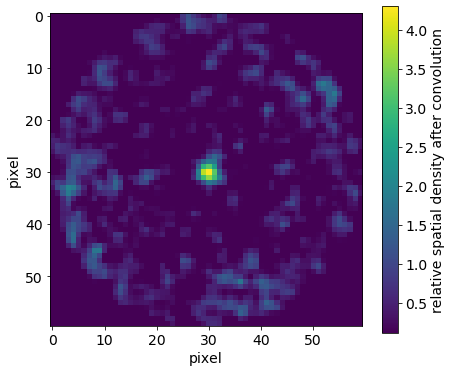

In [9]:
fig, ax = plt.subplots(figsize=(7,6))
im = plt.imshow(clipped)
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.colorbar(label='relative spatial density after convolution');

**One dense peak is visible, let's locate it automatically...**

<a class="anchor" id="peaks"></a>
# Identify peaks
We'll use the `photutils` package to identify 3-sigma peaks in the clipped filtered image.

In [10]:
# find peaks
mean, median, std = stats.sigma_clipped_stats(clipped,sigma=3.0,maxiters=5)
print(mean, median, std)
tbl = find_peaks(clipped,median+3,box_size=small_k*2)

# add ra & dec positions of peaks found
a, b = extent[:2]
xvec = np.arange(a,b,(b-a)/clipped.shape[1])
a, b = extent[2:]
yvec = np.arange(a,b,(b-a)/clipped.shape[0])

tbl['ra'] = xvec[tbl['x_peak']]
tbl['dec'] = yvec[-tbl['y_peak']-1]
print(tbl)

0.15731329900618002 0.11558148731790939 0.08197835282932604
x_peak y_peak     peak_value            ra                dec        
------ ------ ----------------- ------------------ ------------------
    30     30 4.302202741705236 189.58259247008166 -40.88894284071382


# Show the identified density peaks

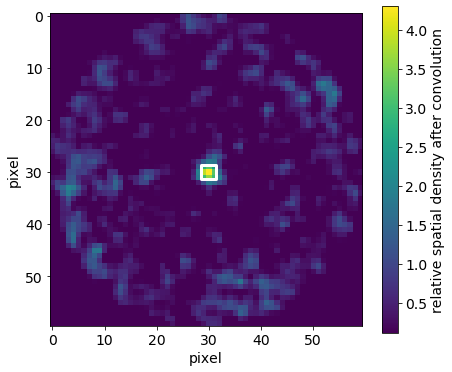

In [11]:
ecs = ['w'] # color of box frame
ax.scatter(tbl['x_peak'],tbl['y_peak'],marker='s',s=tbl['peak_value']*50,c='none',edgecolors=ecs,lw=3) # keeps writing to previous ax
fig  # repeats (the updated) figure

<a class="anchor" id="sia"></a>
# Inspect the image cutouts around the peaks
# *Simple Image Access service*
Data Lab comes with batteries included. Image cutout and download services are built in.

We'll download images from the url "https://datalab.noao.edu/sia/nsa" at our specific ra and dec and store them in an image table, and we'll also write a function to plot several images side-by-side.

In [12]:
# set up SIA and image table
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/nsa"
svc_nsa = sia.SIAService(DEF_ACCESS_URL)
ra = 189.58
dec = -40.89
fov = 0.1

imgTable = svc_nsa.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()
   
# multi panel image plotter
def plot_images(images,geo=None,panelsize=5,titles=list('gri'),cmap=plt.cm.gray_r):
    if geo is None:
        geo = (len(images),1)  # ncols, nrows
        
    fig = plt.figure(figsize=(geo[0]*panelsize,geo[1]*panelsize))
    for j,img in enumerate(images):
        ax = fig.add_subplot(geo[1],geo[0],j+1)
        ax.imshow(img,origin='lower',interpolation='none',cmap=cmap,norm=plt.mpl.colors.PowerNorm(0.1))
        ax.set_title('{:s}'.format(titles[j]))
        plt.axis('off')

# Get images for the white box
Separately plot the g, r, and i images for the region in the white box. 

For each image, the sel condition is used to find the specific image within the image table. For aesthetic reasons, we normalize each image using the image exposure time and zeropoint. We take the zeropoints from the DELVE data processing but they can be approximated by hand (as we do for the i band).

In [13]:
#There is an astrometric offset in the false-color image, so these constants are used to move the images around
#Right now we have it set so that the g and i images are moved 8 pixels to the left
a=0
b=8

In [14]:
sel = (imgTable['proctype'].astype(str)=='InstCal') & (imgTable['prodtype'].astype(str)=='image') & (imgTable['access_estsize'].astype(str)=='311551') & \
    (startswith(imgTable['obs_bandpass'].astype(str),'g'))
#print(imgTable[sel][0])

row = imgTable[sel][0]
url = row['access_url'] # get the download URL
filename = download_file(url,cache=True,show_progress=False,timeout=120)
hdu = fits.open(filename)[0]
i1 = hdu.data
hdr = hdu.header
wcs = WCS(hdr)
#Dimensions of each image need to be equal
image1 = i1[0:1362, b:1233]
#Normalization
#image1 *= (10.0**(0.4*(30.0 - zpt)))/exptime
#from header, exptime=85, expnum=188187, ccdnum=16
zp=31.514652
image1 *= (10.0**(0.4*(30.0-zp)))/hdr["EXPTIME"]

0.0015444942 153.20056 (1362, 1225)


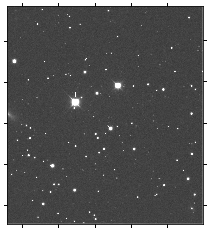

In [15]:
print(image1.min(),image1.max(),image1.shape)
ax = plt.subplot(projection=wcs)
ax.imshow(image1,cmap='gray',vmin=image1.min(),vmax=image1.min()+(image1.max()-image1.min())/150.)

In [16]:
sel = (imgTable['proctype'].astype(str)=='InstCal') & (imgTable['prodtype'].astype(str)=='image') & (imgTable['access_estsize'].astype(str)=='313152') & \
    (startswith(imgTable['obs_bandpass'].astype(str),'r')) 
#print(imgTable[sel][0])

row = imgTable[sel][0]
url = row['access_url'] # get the download URL
filename = download_file(url,cache=True,show_progress=False,timeout=120)
hdu = fits.open(filename)[0]
i2 = hdu.data
hdr = hdu.header
wcs = WCS(hdr)
#Dimensions of each image need to be equal
image2 = i2[0:1362, 0:1233-b]
#Normalization
#image2 *= (10.0**(0.4*(30.0 - zpt)))/exptime
#from header, exptime=85, expnum=188186, ccdnum=16
zp=31.66765
image2 *= (10.0**(0.4*(30.0-zp)))/hdr["EXPTIME"]

0.04137251 131.84407 (1362, 1225)


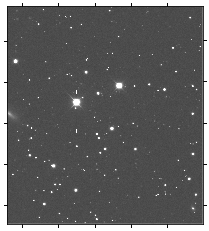

In [17]:
print(image2.min(),image2.max(),image2.shape)
ax = plt.subplot(projection=wcs)
ax.imshow(image2,cmap='gray',vmin=image2.min(),vmax=image2.min()+(image2.max()-image2.min())/70.)

In [18]:
sel = (imgTable['proctype'].astype(str)=='InstCal') & (imgTable['prodtype'].astype(str)=='image') & (imgTable['access_estsize'].astype(str)=='307960') & \
    (startswith(imgTable['obs_bandpass'].astype(str),'i'))
#print(imgTable[sel][0])

row = imgTable[sel][0]
url = row['access_url'] # get the download URL
filename = download_file(url,cache=True,show_progress=False,timeout=120)
hdu = fits.open(filename)[0]
i3 = hdu.data
hdr = hdu.header
wcs = WCS(hdr)
#Dimensions of each image need to be equal
image3 = i3[0:1362, b:1233]
#Normalization
#image3 *= (10.0**(0.4*(30.0 - zpt)))/exptime
#from header, exptime=20, expnum=294524, ccdnum=60
#Note: the expnum and ccdnum for the i image did not produce a zeropoint, 
#so we estimated a zeropoint of 31.0, which worked well to produce a proper false-color image.
zp=31.0
image3 *= (10.0**(0.4*(30.0-zp)))/hdr["EXPTIME"]

10.76793 550.08356 (1362, 1225)


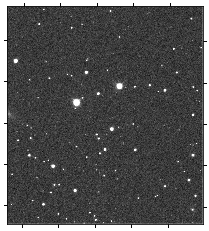

In [19]:
print(image3.min(),image3.max(),image3.shape)
ax = plt.subplot(projection=wcs)
ax.imshow(image3,cmap='gray',vmin=image3.min(),vmax=image3.min()+(image3.max()-image3.min())/100.)

# Create a false-color 3-band image
Use the make_lupton_rgb function to combine the g, r, and i images in a false-color 3-band image

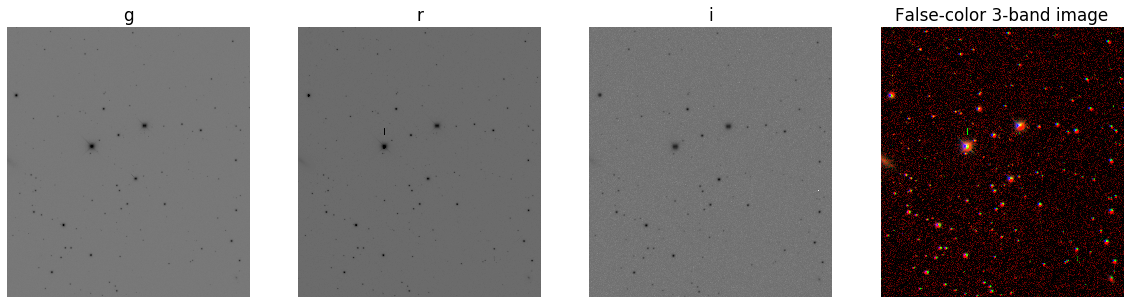

In [20]:
bands = list('gri')
images=[image1, image2, image3]
images = [im-np.median(im) for im in images] # subtract median from all images for better scaling
images += [make_lupton_rgb(*images[::-1],stretch=1)] # add a 3-color composite image
plot_images(images,geo=(4,1),titles=bands+['False-color 3-band image'])

<a class="anchor" id="cmdiagrams"></a>
# Query the database for stars near the peak
Get photometry of stars within a 5 arcmin radius of the density peak.

In [21]:
def makequery(ra0,dec0,radius0):
    query_template = """
SELECT ra,dec,mag_auto_g,mag_auto_r,mag_auto_i FROM delve_dr1.objects
  WHERE q3c_radial_query(ra, dec, {0}, {1}, {2})
    AND mag_auto_g BETWEEN 14 AND 25""" 
    query = query_template.format(ra0,dec0,radius0)
    
    return query

In [22]:
query0 = makequery(tbl['ra'][0],tbl['dec'][0], 5./60.) # center ra & dec
response = qc.query(sql=query0) # using sql argument instead of the default adql
R0 = convert(response,'pandas')
print(R0.head()) # a pandas method

           ra        dec  mag_auto_g  mag_auto_r  mag_auto_i
0  189.486304 -40.869083     14.9702        99.0        99.0
1  189.571458 -40.892083     14.0975        99.0        99.0
2  189.474678 -40.876589     14.3569        99.0        99.0
3  189.669422 -40.924268     14.9004        99.0        99.0
4  189.548861 -40.918677     14.3241        99.0        99.0


# Compute color

In [23]:
R0['g_r'] = R0['mag_auto_g'] - R0['mag_auto_r']
print( R0.head())

           ra        dec  mag_auto_g  mag_auto_r  mag_auto_i      g_r
0  189.486304 -40.869083     14.9702        99.0        99.0 -84.0298
1  189.571458 -40.892083     14.0975        99.0        99.0 -84.9025
2  189.474678 -40.876589     14.3569        99.0        99.0 -84.6431
3  189.669422 -40.924268     14.9004        99.0        99.0 -84.0996
4  189.548861 -40.918677     14.3241        99.0        99.0 -84.6759


# Color-magnitude diagrams of the peak

In [24]:
def plotpanel(axid,x,y,title='',xlim=(-1,2),ylim=(25.2,14)):
    ax = fig.add_subplot(axid)
    ax.scatter(x,y,marker='.',s=10, alpha=0.8)
    ax.set_xlabel(x.name)
    ax.set_ylabel(y.name)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)

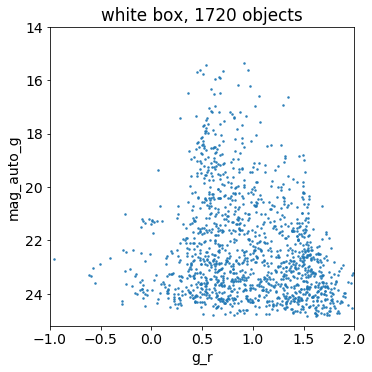

In [25]:
fig = plt.figure(figsize=(12,5.5))
plotpanel(121,R0['g_r'],R0['mag_auto_g'],'white box, {:d} objects'.format(len(R0)))

Compare w/ Figure 3 of [Mau et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...890..136M/abstract)

# Save your photometry table
If you wish, you can now save your photometry table for Centaurus I to a local file and take it with you.

In [26]:
outfile = 'cen1.csv'
R0.to_csv(outfile,index=False)

[cen1.csv](cen1.csv) <-- Download the file as you please.

# Some ideas for improvement

* Find overdensities elsewhere (everywhere!)

* optimize kernel sizes, computation, proper wavelets

# Some resources


Mau et al. (2019, ApJ, 890, 136) "Two Ultra-Faint Milky Way Stellar Systems Discovered in Early Data from the DECam Local Volume Exploration Survey": https://ui.adsabs.harvard.edu/abs/2020ApJ...890..136M/abstract

Drlica-Wagner et al. (2021) "The DECam Local Volume Exploration Survey: Overview and First Data Release": https://ui.adsabs.harvard.edu/abs/2021arXiv210307476D/abstract

Stanford et al. (2005, ApJ, 634, 2, L129) "An IR-selected Galaxy Cluster at z = 1.41": http://adsabs.harvard.edu/abs/2005ApJ...634L.129S

Koposov et al. (2008, ApJ, 686, 279) "The Luminosity Function of the Milky Way Satellites": http://adsabs.harvard.edu/abs/2008ApJ...686..279K